In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass
    
class BN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(BN, self).__init__()
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
    def forward(self, x):
        
        beta = x.mean(0, keepdim=True)
        alpha = ((x-beta)**2).mean(0, keepdim=True).sqrt()

        # Normalize
        nx = (x-beta)/alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return o

    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
        self.gain = nn.Parameter(torch.ones(layersize))
        self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        # Adjust using learned parameters
        o = self.gain*nx + self.bias
        return  o
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Eu = u.mean(0, keepdim=True)
            Euu = (u**2).mean(0, keepdim=True)
            Ev = v.mean(0, keepdim=True)
            Evv = (v**2).mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * (2*(Euv))
        self.beta = (1-eta)*self.beta + eta * (2*Ev)
        
#         self.eta = eta * 0.9995


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [3]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [4]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0
        
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    # plt.plot(bn_losses[0], bn_losses[1], label="BN")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    # plt.plot(bn_losses[0], bn_losses[1], label="BN")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Tests

In [5]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


Training IP Net. Run 1
[1] loss: 0.969
[2] loss: 0.352
[3] loss: 0.258
[4] loss: 0.214
[5] loss: 0.185
[6] loss: 0.161
[7] loss: 0.144
[8] loss: 0.130
[9] loss: 0.117
[10] loss: 0.109
[11] loss: 0.102
[12] loss: 0.093
[13] loss: 0.085
[14] loss: 0.083
[15] loss: 0.076
[16] loss: 0.070
[17] loss: 0.068
[18] loss: 0.065
[19] loss: 0.058
[20] loss: 0.055
[21] loss: 0.055
[22] loss: 0.048
[23] loss: 0.049
[24] loss: 0.045
[25] loss: 0.045
[26] loss: 0.039
[27] loss: 0.038
[28] loss: 0.036
[29] loss: 0.035
[30] loss: 0.037
[31] loss: 0.034
[32] loss: 0.030
[33] loss: 0.033
[34] loss: 0.029
[35] loss: 0.028
[36] loss: 0.026
[37] loss: 0.027
[38] loss: 0.024
[39] loss: 0.027
[40] loss: 0.022
Finished training!

Training Standard Net. Run 1
[1] loss: 0.951
[2] loss: 0.337
[3] loss: 0.240
[4] loss: 0.188
[5] loss: 0.163
[6] loss: 0.140
[7] loss: 0.127
[8] loss: 0.116
[9] loss: 0.104
[10] loss: 0.096
[11] loss: 0.089
[12] loss: 0.081
[13] loss: 0.075
[14] loss: 0.070
[15] loss: 0.065
[16] loss: 

[18] loss: 0.050
[19] loss: 0.047
[20] loss: 0.045
[21] loss: 0.041
[22] loss: 0.044
[23] loss: 0.038
[24] loss: 0.038
[25] loss: 0.035
[26] loss: 0.031
[27] loss: 0.033
[28] loss: 0.032
[29] loss: 0.030
[30] loss: 0.029
[31] loss: 0.027
[32] loss: 0.027
[33] loss: 0.027
[34] loss: 0.025
[35] loss: 0.024
[36] loss: 0.025
[37] loss: 0.020
[38] loss: 0.024
[39] loss: 0.022
[40] loss: 0.021
Finished training!

Training IP Net. Run 7
[1] loss: 0.901
[2] loss: 0.326
[3] loss: 0.250
[4] loss: 0.207
[5] loss: 0.178
[6] loss: 0.155
[7] loss: 0.142
[8] loss: 0.120
[9] loss: 0.110
[10] loss: 0.102
[11] loss: 0.091
[12] loss: 0.086
[13] loss: 0.082
[14] loss: 0.074
[15] loss: 0.069
[16] loss: 0.064
[17] loss: 0.063
[18] loss: 0.057
[19] loss: 0.054
[20] loss: 0.048
[21] loss: 0.046
[22] loss: 0.045
[23] loss: 0.040
[24] loss: 0.040
[25] loss: 0.036
[26] loss: 0.039
[27] loss: 0.035
[28] loss: 0.033
[29] loss: 0.030
[30] loss: 0.031
[31] loss: 0.030
[32] loss: 0.028
[33] loss: 0.026
[34] loss: 0.0

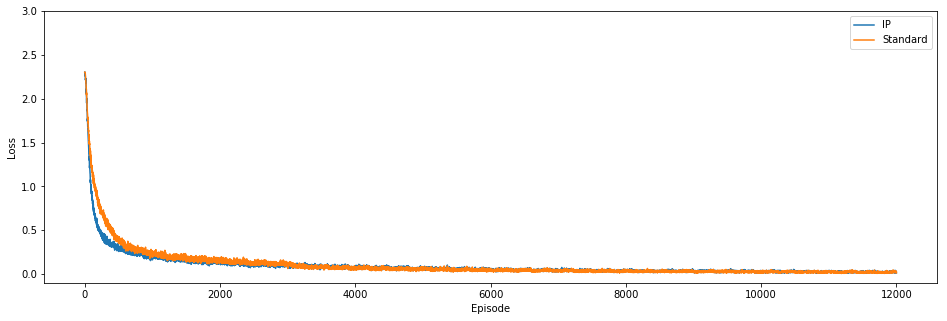

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10
epochs = 40

int_lr = 0.2
syn_lr = 0.001

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.669
[2] loss: 0.254
[3] loss: 0.198
[4] loss: 0.168
[5] loss: 0.148
[6] loss: 0.129
[7] loss: 0.118
[8] loss: 0.109
[9] loss: 0.099
[10] loss: 0.094
[11] loss: 0.084
[12] loss: 0.079
[13] loss: 0.074
[14] loss: 0.071
[15] loss: 0.067
[16] loss: 0.060
[17] loss: 0.061
[18] loss: 0.052
[19] loss: 0.051
[20] loss: 0.052
[21] loss: 0.046
[22] loss: 0.049
[23] loss: 0.044
[24] loss: 0.039
[25] loss: 0.042
[26] loss: 0.036
[27] loss: 0.038
[28] loss: 0.034
[29] loss: 0.037
[30] loss: 0.034
[31] loss: 0.035
[32] loss: 0.034
[33] loss: 0.030
[34] loss: 0.030
[35] loss: 0.029
[36] loss: 0.026
[37] loss: 0.024
[38] loss: 0.026
[39] loss: 0.029
[40] loss: 0.023
Finished training!

Training Standard Net. Run 1
[1] loss: 0.639
[2] loss: 0.267
[3] loss: 0.197
[4] loss: 0.155
[5] loss: 0.132
[6] loss: 0.119
[7] loss: 0.113
[8] loss: 0.097
[9] loss: 0.096
[10] loss: 0.089
[11] loss: 0.082
[12] loss: 0.073
[13] loss: 0.073
[14] loss: 0.070
[15] loss: 0.065
[16] loss: 

[18] loss: 0.059
[19] loss: 0.053
[20] loss: 0.054
[21] loss: 0.063
[22] loss: 0.053
[23] loss: 0.049
[24] loss: 0.052
[25] loss: 0.047
[26] loss: 0.052
[27] loss: 0.044
[28] loss: 0.048
[29] loss: 0.049
[30] loss: 0.051
[31] loss: 0.044
[32] loss: 0.042
[33] loss: 0.047
[34] loss: 0.046
[35] loss: 0.044
[36] loss: 0.046
[37] loss: 0.042
[38] loss: 0.049
[39] loss: 0.051
[40] loss: 0.044
Finished training!

Training IP Net. Run 7
[1] loss: 0.707
[2] loss: 0.296
[3] loss: 0.222
[4] loss: 0.183
[5] loss: 0.166
[6] loss: 0.146
[7] loss: 0.126
[8] loss: 0.119
[9] loss: 0.106
[10] loss: 0.097
[11] loss: 0.087
[12] loss: 0.081
[13] loss: 0.077
[14] loss: 0.068
[15] loss: 0.065
[16] loss: 0.064
[17] loss: 0.056
[18] loss: 0.056
[19] loss: 0.052
[20] loss: 0.052
[21] loss: 0.046
[22] loss: 0.041
[23] loss: 0.045
[24] loss: 0.039
[25] loss: 0.043
[26] loss: 0.034
[27] loss: 0.035
[28] loss: 0.039
[29] loss: 0.033
[30] loss: 0.032
[31] loss: 0.030
[32] loss: 0.029
[33] loss: 0.032
[34] loss: 0.0

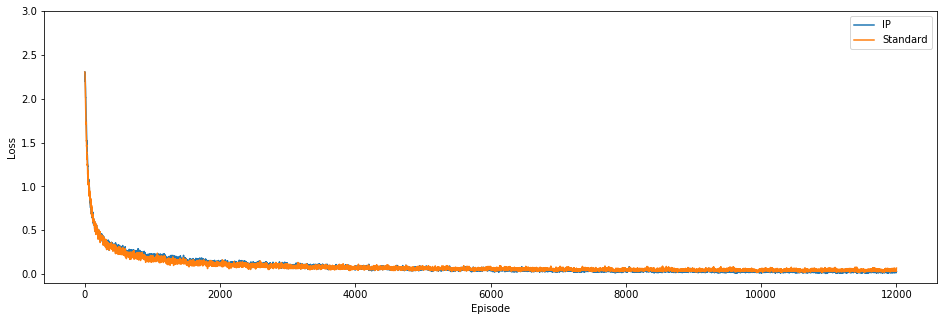

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.003

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.939
[2] loss: 0.305
[3] loss: 0.215
[4] loss: 0.173
[5] loss: 0.140
[6] loss: 0.126
[7] loss: 0.114
[8] loss: 0.104
[9] loss: 0.096
[10] loss: 0.090
[11] loss: 0.081
[12] loss: 0.078
[13] loss: 0.065
[14] loss: 0.065
[15] loss: 0.067
[16] loss: 0.061
[17] loss: 0.060
[18] loss: 0.059
[19] loss: 0.055
[20] loss: 0.050
[21] loss: 0.047
[22] loss: 0.050
[23] loss: 0.052
[24] loss: 0.044
[25] loss: 0.048
[26] loss: 0.041
[27] loss: 0.036
[28] loss: 0.037
[29] loss: 0.041
[30] loss: 0.041
[31] loss: 0.036
[32] loss: 0.036
[33] loss: 0.037
[34] loss: 0.037
[35] loss: 0.029
[36] loss: 0.031
[37] loss: 0.029
[38] loss: 0.033
[39] loss: 0.032
[40] loss: 0.027
Finished training!

Training Standard Net. Run 1
[1] loss: 0.943
[2] loss: 0.690
[3] loss: 0.497
[4] loss: 0.412
[5] loss: 0.382
[6] loss: 0.392
[7] loss: 0.385
[8] loss: 0.356
[9] loss: 0.359
[10] loss: 0.348
[11] loss: 0.338
[12] loss: 0.339
[13] loss: 0.358
[14] loss: 0.348
[15] loss: 0.369
[16] loss: 

[18] loss: 0.387
[19] loss: 0.389
[20] loss: 0.390
[21] loss: 0.392
[22] loss: 0.402
[23] loss: 0.403
[24] loss: 0.430
[25] loss: 0.401
[26] loss: 0.393
[27] loss: 0.413
[28] loss: 0.458
[29] loss: 0.482
[30] loss: 0.445
[31] loss: 0.472
[32] loss: 0.496
[33] loss: 0.459
[34] loss: 0.546
[35] loss: 0.560
[36] loss: 0.498
[37] loss: 0.525
[38] loss: 0.540
[39] loss: 0.486
[40] loss: 0.497
Finished training!

Training IP Net. Run 7
[1] loss: 0.744
[2] loss: 0.283
[3] loss: 0.211
[4] loss: 0.169
[5] loss: 0.148
[6] loss: 0.129
[7] loss: 0.113
[8] loss: 0.101
[9] loss: 0.095
[10] loss: 0.089
[11] loss: 0.081
[12] loss: 0.078
[13] loss: 0.077
[14] loss: 0.068
[15] loss: 0.068
[16] loss: 0.072
[17] loss: 0.058
[18] loss: 0.055
[19] loss: 0.068
[20] loss: 0.056
[21] loss: 0.051
[22] loss: 0.049
[23] loss: 0.047
[24] loss: 0.041
[25] loss: 0.048
[26] loss: 0.048
[27] loss: 0.042
[28] loss: 0.042
[29] loss: 0.038
[30] loss: 0.038
[31] loss: 0.039
[32] loss: 0.037
[33] loss: 0.037
[34] loss: 0.0

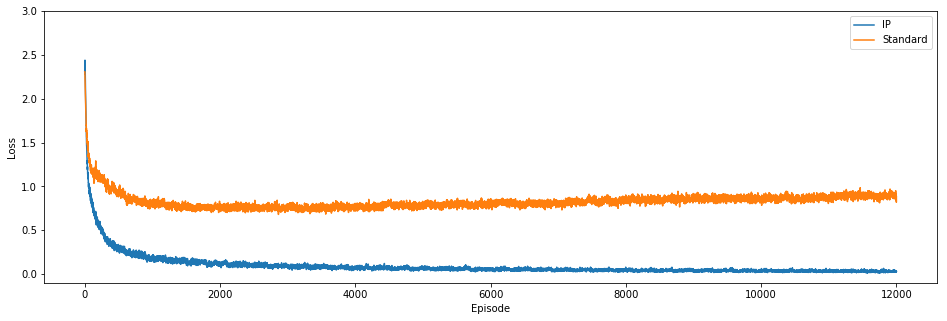

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.01

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.831
[2] loss: 0.310
[3] loss: 0.225
[4] loss: 0.186
[5] loss: 0.159
[6] loss: 0.139
[7] loss: 0.129
[8] loss: 0.117
[9] loss: 0.101
[10] loss: 0.100
[11] loss: 0.092
[12] loss: 0.097
[13] loss: 0.088
[14] loss: 0.085
[15] loss: 0.082
[16] loss: 0.078
[17] loss: 0.065
[18] loss: 0.067
[19] loss: 0.066
[20] loss: 0.060
[21] loss: 0.058
[22] loss: 0.067
[23] loss: 0.059
[24] loss: 0.061
[25] loss: 0.055
[26] loss: 0.050
[27] loss: 0.054
[28] loss: 0.059
[29] loss: 0.055
[30] loss: 0.058
[31] loss: 0.051
[32] loss: 0.048
[33] loss: 0.051
[34] loss: 0.044
[35] loss: 0.048
[36] loss: 0.056
[37] loss: 0.047
[38] loss: 0.047
[39] loss: 0.048
[40] loss: 0.048
Finished training!

Training Standard Net. Run 1
[1] loss: 1.313
[2] loss: 0.990
[3] loss: 0.770
[4] loss: 0.712
[5] loss: 0.692
[6] loss: 0.694
[7] loss: 0.710
[8] loss: 0.748
[9] loss: 0.802
[10] loss: 0.703
[11] loss: 0.671
[12] loss: 0.643
[13] loss: 0.730
[14] loss: 0.854
[15] loss: 0.862
[16] loss: 

[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
[21] loss: 2.310
[22] loss: 2.310
[23] loss: 2.310
[24] loss: 2.310
[25] loss: 2.310
[26] loss: 2.310
[27] loss: 2.310
[28] loss: 2.310
[29] loss: 2.310
[30] loss: 2.310
[31] loss: 2.310
[32] loss: 2.310
[33] loss: 2.310
[34] loss: 2.310
[35] loss: 2.310
[36] loss: 2.310
[37] loss: 2.310
[38] loss: 2.310
[39] loss: 2.310
[40] loss: 2.310
Finished training!

Training IP Net. Run 7
[1] loss: 0.895
[2] loss: 0.300
[3] loss: 0.208
[4] loss: 0.167
[5] loss: 0.143
[6] loss: 0.130
[7] loss: 0.114
[8] loss: 0.108
[9] loss: 0.095
[10] loss: 0.096
[11] loss: 0.085
[12] loss: 0.086
[13] loss: 0.078
[14] loss: 0.074
[15] loss: 0.075
[16] loss: 0.073
[17] loss: 0.065
[18] loss: 0.058
[19] loss: 0.060
[20] loss: 0.064
[21] loss: 0.059
[22] loss: 0.057
[23] loss: 0.050
[24] loss: 0.060
[25] loss: 0.056
[26] loss: 0.046
[27] loss: 0.050
[28] loss: 0.050
[29] loss: 0.056
[30] loss: 0.045
[31] loss: 0.049
[32] loss: 0.052
[33] loss: 0.042
[34] loss: 0.0

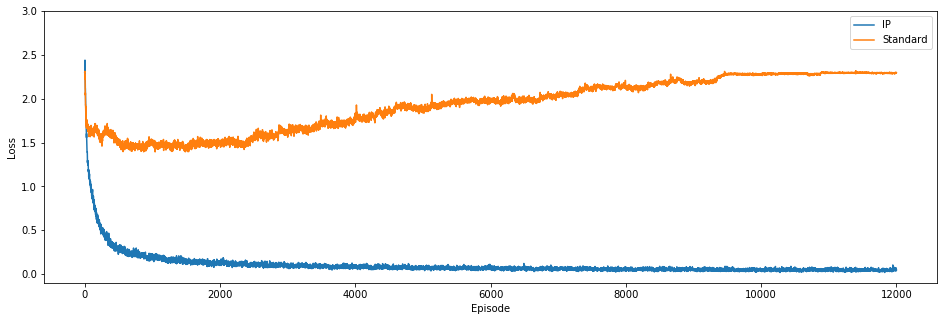

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.016

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Tests

In [10]:
batchSize = 200

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Training IP Net. Run 1
[1] loss: 1.895
[2] loss: 1.731
[3] loss: 1.639
[4] loss: 1.570
[5] loss: 1.517
[6] loss: 1.460
[7] loss: 1.415
[8] loss: 1.371
[9] loss: 1.335
[10] loss: 1.289
[11] loss: 1.257
[12] loss: 1.217
[13] loss: 1.185
[14] loss: 1.150
[15] loss: 1.113
[16] loss: 1.079
[17] loss: 1.040
[18] loss: 1.006
[19] loss: 0.975
[20] loss: 0.939
[21] loss: 0.909
[22] loss: 0.880
[23] loss: 0.842
[24] loss: 0.816
[25] loss: 0.782
[26] loss: 0.751
[27] loss: 0.730
[28] loss: 0.701
[29] loss: 0.682
[30] loss: 0.647
[31] loss: 0.621
[32] loss: 0.608
[33] loss: 0.592
[34] loss: 0.568
[35] loss: 0.545
[36] loss: 0.524
[37] loss: 0.514
[38] loss: 0.489
[39] loss: 0.479
[40] loss: 0.474
Finished training!

Training Standard Net. Run 1
[1] loss: 1.939
[2] loss: 1.773
[3] loss: 1.687
[4] loss: 1.624
[5] loss: 1.568
[6] loss: 1.522
[7] loss: 1.486
[8] loss: 1.442
[9] loss: 1.408
[10] loss: 1.374
[11] loss: 1.344
[12] loss: 1.305
[13] loss: 1.281
[14] loss: 1.244
[15] loss: 1.216
[16] loss: 

[18] loss: 1.108
[19] loss: 1.078
[20] loss: 1.049
[21] loss: 1.023
[22] loss: 0.994
[23] loss: 0.975
[24] loss: 0.949
[25] loss: 0.925
[26] loss: 0.899
[27] loss: 0.879
[28] loss: 0.855
[29] loss: 0.832
[30] loss: 0.810
[31] loss: 0.789
[32] loss: 0.769
[33] loss: 0.757
[34] loss: 0.733
[35] loss: 0.713
[36] loss: 0.700
[37] loss: 0.677
[38] loss: 0.661
[39] loss: 0.639
[40] loss: 0.641
Finished training!

Training IP Net. Run 7
[1] loss: 1.868
[2] loss: 1.699
[3] loss: 1.608
[4] loss: 1.558
[5] loss: 1.502
[6] loss: 1.451
[7] loss: 1.409
[8] loss: 1.365
[9] loss: 1.326
[10] loss: 1.283
[11] loss: 1.246
[12] loss: 1.211
[13] loss: 1.175
[14] loss: 1.129
[15] loss: 1.098
[16] loss: 1.063
[17] loss: 1.018
[18] loss: 0.986
[19] loss: 0.953
[20] loss: 0.923
[21] loss: 0.883
[22] loss: 0.857
[23] loss: 0.821
[24] loss: 0.793
[25] loss: 0.759
[26] loss: 0.734
[27] loss: 0.710
[28] loss: 0.674
[29] loss: 0.650
[30] loss: 0.630
[31] loss: 0.613
[32] loss: 0.582
[33] loss: 0.569
[34] loss: 0.5

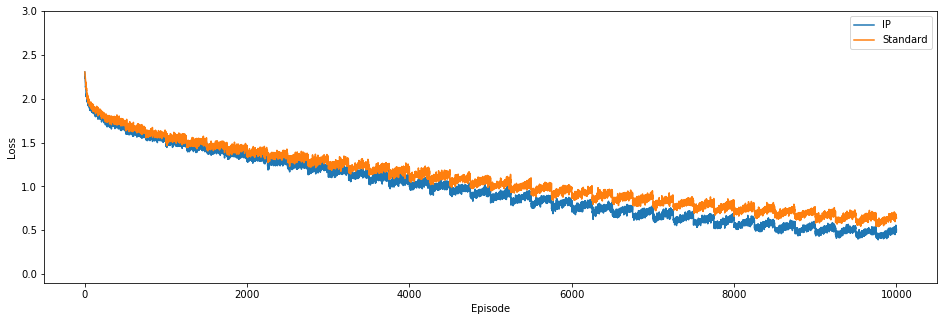

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.001

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.003
[2] loss: 1.850
[3] loss: 1.747
[4] loss: 1.669
[5] loss: 1.592
[6] loss: 1.533
[7] loss: 1.477
[8] loss: 1.423
[9] loss: 1.389
[10] loss: 1.337
[11] loss: 1.313
[12] loss: 1.249
[13] loss: 1.189
[14] loss: 1.273
[15] loss: 1.126
[16] loss: 1.065
[17] loss: 1.021
[18] loss: 0.969
[19] loss: 0.925
[20] loss: 0.884
[21] loss: 0.840
[22] loss: 0.799
[23] loss: 0.762
[24] loss: 0.722
[25] loss: 0.691
[26] loss: 0.651
[27] loss: 0.626
[28] loss: 0.599
[29] loss: 0.565
[30] loss: 0.532
[31] loss: 0.512
[32] loss: 0.480
[33] loss: 0.470
[34] loss: 0.456
[35] loss: 0.422
[36] loss: 0.411
[37] loss: 0.402
[38] loss: 0.378
[39] loss: 0.369
[40] loss: 0.350
Finished training!

Training Standard Net. Run 1
[1] loss: 2.125
[2] loss: 2.079
[3] loss: 2.025
[4] loss: 2.001
[5] loss: 1.982
[6] loss: 1.976
[7] loss: 1.956
[8] loss: 1.957
[9] loss: 1.948
[10] loss: 1.944
[11] loss: 1.934
[12] loss: 1.936
[13] loss: 1.929
[14] loss: 1.935
[15] loss: 1.929
[16] loss: 

[18] loss: 1.907
[19] loss: 1.898
[20] loss: 1.901
[21] loss: 1.896
[22] loss: 1.889
[23] loss: 1.895
[24] loss: 1.889
[25] loss: 1.886
[26] loss: 1.894
[27] loss: 1.883
[28] loss: 1.879
[29] loss: 1.874
[30] loss: 1.869
[31] loss: 1.869
[32] loss: 1.858
[33] loss: 1.860
[34] loss: 1.859
[35] loss: 1.853
[36] loss: 1.850
[37] loss: 1.848
[38] loss: 1.849
[39] loss: 1.856
[40] loss: 1.849
Finished training!

Training IP Net. Run 7
[1] loss: 1.982
[2] loss: 1.861
[3] loss: 1.762
[4] loss: 1.672
[5] loss: 1.607
[6] loss: 1.535
[7] loss: 1.474
[8] loss: 1.418
[9] loss: 1.365
[10] loss: 1.324
[11] loss: 1.265
[12] loss: 1.222
[13] loss: 1.172
[14] loss: 1.112
[15] loss: 1.072
[16] loss: 1.019
[17] loss: 0.977
[18] loss: 0.933
[19] loss: 0.881
[20] loss: 0.834
[21] loss: 0.801
[22] loss: 0.755
[23] loss: 0.719
[24] loss: 0.696
[25] loss: 0.658
[26] loss: 0.631
[27] loss: 0.598
[28] loss: 0.570
[29] loss: 0.551
[30] loss: 0.513
[31] loss: 0.503
[32] loss: 0.474
[33] loss: 0.462
[34] loss: 0.4

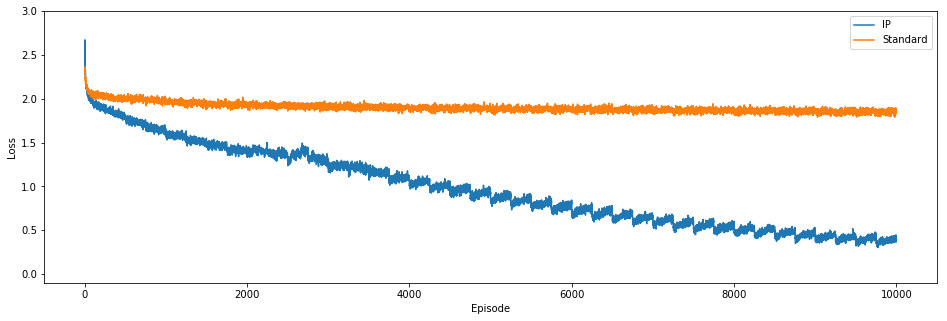

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 300

test_runs = 10
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.003

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 300

test_runs = 10
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.006

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.014
[2] loss: 1.860
[3] loss: 1.779
[4] loss: 2.029
[5] loss: 2.303
[6] loss: 2.312
[7] loss: 2.312
[8] loss: 2.312
[9] loss: 2.312
[10] loss: 2.312
[11] loss: 2.312
[12] loss: 2.312
[13] loss: 2.312
[14] loss: 2.312
[15] loss: 2.312
[16] loss: 2.312
[17] loss: 2.312
[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.314
Finished training!

Training Standard Net. Run 1
[1] loss: 2.313
[2] loss: 2.267
[3] loss: 2.231
[4] loss: 2.216
[5] loss: 2.193
[6] loss: 2.179
[7] loss: 2.162
[8] loss: 2.162
[9] loss: 2.154
[10] loss: 2.147
[11] loss: 2.151
[12] loss: 2.153
[13] loss: 2.149
[14] loss: 2.133
[15] loss: 2.146
[16] loss: 

Process Process-10163:
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-10164:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_in

Traceback (most recent call last):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-7815abdb09ea>", line 13, in <module>
    run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)
  File "<ipython-input-4-ef8d6a08c096>", line 84, in run_cifar_experiment
    standard_losses += train_deep_model(net, optimizer2, seed, epochs)
  File "<ipython-input-4-ef8d6a08c096>", line 14, in train_deep_model
    for i, data in enumerate(trainloader):
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/home/n5shaw/.conda/envs/nps/lib/python3.5/multiprocessing/queues.py", line 343, in get
 

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 300

test_runs = 10
epochs = 40

test_runs = 10

int_lr = 0.2
syn_lr = 0.003

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = net(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the standard network on the 10000 test images: %.4f %%' % (
    100 * correct / total))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        y = IPnet(images)
        _, predicted = torch.max(y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the IP network on the 10000 test images: %.4f %%' % (
    100 * correct / total))